<a href="https://colab.research.google.com/github/Praxis-QR/DeepLearning/blob/main/AI_DL_Chapter_6A_RNN_predictive_typing_Characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://1.bp.blogspot.com/-WAjYIaQofo0/YEB0cQsSGSI/AAAAAAAAkoE/TpQcWBRGtu0N010lmiTS9cFHuGwXB45PQCLcBGAsYHQ/s16000/colabHeader00.png)<br>

<hr>

[Prithwis Mukerjee](http://www.yantrajaal.com) / [Praxis Business School](http://praxis.ac.in/) / [Book Website](http://aidl4managers.blogspot.com) 

Based on https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218 <br>
https://medium.com/analytics-vidhya/build-a-simple-predictive-keyboard-using-python-and-keras-b78d3c88cffb <br>
https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/


Use a GPU Runtime

In [1]:
import numpy as np
np.random.seed(39)
import tensorflow as tf
tf.random.set_seed(39)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
#from keras.optimizers import RMSprop -- https://stackoverflow.com/questions/64844140/importerror-cannot-import-name-rmsprop-from-keras-optimizers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
from nltk.tokenize import RegexpTokenizer
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5
import re

In [ ]:
#This step is required if and only if you wish to store the RNN model ( or any file on Google Colab) to Google Drive
#
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#Lists the contents of the Google Drive of the GMail account that was connected to in the previous step
#
#!ls /content/drive/MyDrive/Praxis/'Non Syllabus'/'AI_DL for Business Managers'/Data

In [2]:
# BEYOND GOOD AND EVIL  - Friedrich Nietzsche 
#!wget https://www.gutenberg.org/files/4363/4363.txt
!wget https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/4363.txt

# Moon and Sixpence - Somerset Maugham
#!wget https://www.gutenberg.org/files/222/222.txt
!wget https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/222.txt

#The Adventures of Sherlock Holmes, by Arthur Conan Doyle
#!wget https://www.gutenberg.org/files/1661/1661.txt
#!wget https://www.gutenberg.org/files/1661/1661-0.txt
!wget https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/1661-0.txt



--2021-10-25 04:13:10--  https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/4363.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402299 (393K) [text/plain]
Saving to: ‘4363.txt’

4363.txt            100%[===================>] 392.87K  --.-KB/s    in 0.03s   

2021-10-25 04:13:11 (11.5 MB/s) - ‘4363.txt’ saved [402299/402299]

--2021-10-25 04:13:11--  https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/data/222.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 426784 (417K) [text/plain]
Saving to: ‘2

In [3]:
def readClean(fileName):
    text = open(fileName).read().lower()
    len(text),text
    text = text[1500:]                                                   # remove the first 1500 characters   
    size = len(text)                                                     # length of string
    text = text[:size - 18000]                                           # remove last 18000 characters of string, the license
    #text = re.sub('[-!@#$\n\t.,"*%?><;:()/\[\]0123456789&_]', ' ', text) # replace [!@#$]\n\twith space
    text = re.sub('[-!@#$\n\t.,"*%?><;:()/\[\]0123456789&_£½àâæèœ—‘’“”é]', ' ', text)
    text = re.sub('\s+',' ',text)                                        # replace multiple white space with single space
    return text

In [4]:
text = readClean('222.txt')+' '+readClean('4363.txt')+' '+readClean('1661-0.txt')
print('corpus length:', len(text), 'characters')

corpus length: 1295097 characters


In [5]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('unique chars: ', len(chars))
#print(chars)
#print(char_indices)

unique chars:  28


In [6]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print('Number of training examples: ',len(sentences))

Number of training examples:  431686


In [8]:
%%time
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

CPU times: user 6.18 s, sys: 257 ms, total: 6.44 s
Wall time: 6.44 s


In [9]:
#sentences[101],next_chars[101]
#X[101][0]
#y[101]

In [10]:
X.shape,y.shape

((431686, 40, 28), (431686, 28))

In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
#model.add(Dropout(0.2))
#model.add(LSTM(128))
#model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               80384     
_________________________________________________________________
dense (Dense)                (None, 28)                3612      
_________________________________________________________________
activation (Activation)      (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


In [12]:
#optimizer = RMSprop(lr=0.01)
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
%%time
#this model fitting will take some time
# we do not run this model, load a previously fitted model
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history
#
#
# if you do not run this model, skip a couple of cells and download a trained model

Epoch 1/20
3204/3204 [==============================] - 58s 16ms/step - loss: 1.7043 - accuracy: 0.4768 - val_loss: 1.4974 - val_accuracy: 0.5374
Epoch 2/20
3204/3204 [==============================] - 49s 15ms/step - loss: 1.4641 - accuracy: 0.5438 - val_loss: 1.4222 - val_accuracy: 0.5552
Epoch 3/20
3204/3204 [==============================] - 49s 15ms/step - loss: 1.4099 - accuracy: 0.5597 - val_loss: 1.4118 - val_accuracy: 0.5557
Epoch 4/20
3204/3204 [==============================] - 49s 15ms/step - loss: 1.3803 - accuracy: 0.5678 - val_loss: 1.3909 - val_accuracy: 0.5621
Epoch 5/20
3204/3204 [==============================] - 48s 15ms/step - loss: 1.3605 - accuracy: 0.5735 - val_loss: 1.3854 - val_accuracy: 0.5672
Epoch 6/20
3204/3204 [==============================] - 49s 15ms/step - loss: 1.3473 - accuracy: 0.5772 - val_loss: 1.3815 - val_accuracy: 0.5714
Epoch 7/20
3204/3204 [==============================] - 48s 15ms/step - loss: 1.3363 - accuracy: 0.5804 - val_loss: 1.3774 -

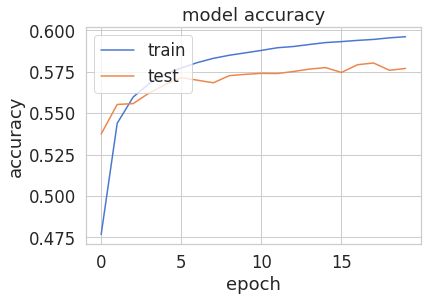

In [14]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

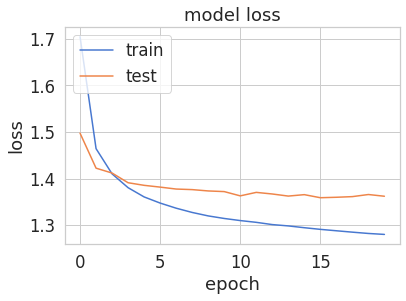

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [16]:
model.save('C3S40L128x1.h5')
pickle.dump(history, open("history.p", "wb"))

In [17]:
#Download the trained model from author's Google Drive / Github
#https://drive.google.com/file/d/1dbe6_GGRJ3Y3gN5bRN0Df4I1ZwfK2KI2/view?usp=sharing
#!gdown https://drive.google.com/uc?id=1dbe6_GGRJ3Y3gN5bRN0Df4I1ZwfK2KI2
#!gdown https://drive.google.com/uc?id=1fUitfV9gCtTsyuU29sMcX1m6Ufox4N8y   #more contemporary model
!wget -O C3S40L128x1.h5 https://github.com/Praxis-QR/DeepLearning/blob/main/models/C3S40L128x1.h5?raw=true
!wget -O history.p https://github.com/Praxis-QR/DeepLearning/blob/main/models/history.p?raw=true

--2021-10-25 04:36:16--  https://github.com/Praxis-QR/DeepLearning/blob/main/models/C3S40L128x1.h5?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Praxis-QR/DeepLearning/raw/main/models/C3S40L128x1.h5 [following]
--2021-10-25 04:36:16--  https://github.com/Praxis-QR/DeepLearning/raw/main/models/C3S40L128x1.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/models/C3S40L128x1.h5 [following]
--2021-10-25 04:36:16--  https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/models/C3S40L128x1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... con

In [18]:
model = load_model("C3S40L128x1.h5")
history = pickle.load(open("history.p", "rb"))

In [19]:
def Text2Array(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))    
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
    return x

In [20]:
Text2Array("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [21]:
#Gets the indices of the top_n values in the array of predictions
#Wicked programming
def TopIndices(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [22]:
#given an initial input sequence, predicts the next char
#creates a new sequence by removing first char of initial input and 
#appending the predicted character
#keeps on doing this until next char is blank
#and has generated at least one more character
#
def GetSequence(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = Text2Array(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = TopIndices(preds, top_n=1)[0]
        next_char = indices_char[next_index]        
        text = text[1:] + next_char
        completion += next_char
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [23]:
#
# gets top_n first characters 
# for each first character, gets a sequence of predicted subsequent characters
#
def GetNextOptions(text, n=3):
    x = Text2Array(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = TopIndices(preds, n)
    options = []
    for idx in next_indices:
        first_char = indices_char[idx]
        next_chars = GetSequence(text[1:]+first_char)
        option = first_char + next_chars
        options.append(option)
    return(options)
    #return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [24]:
quotes = [
    "It is not a lack of love but a lack of friendship that makes unhappy marriages",
    "That which does not kill us makes us stronger",
    "I'm not upset that you lied to me I'm upset that from now on I can't believe you",
    "And those who were seen dancing were thought to be insane by those who could not hear the music",
    "It is hard enough to remember my opinions without also remembering my reasons for them"
]

In [25]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(GetNextOptions(seq, 5))
    print()

it is not a lack of love but a lack of f
['act ', 'riend ', 'inger ', 'or ', 'ellow ']

that which does not kill us makes us str


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


['ickland ', 'oeve ', 'eet ', 'ange ', 'uggle ']

i'm not upset that you lied to me i'm up
['on ', ' the ', 'and ', 'ing ', 'ered ']

and those who were seen dancing were tho
['ugh ', 'se ', 'pbeagent ', 'ke ', 've ']

it is hard enough to remember my opinion
[' of ', 's ', 'g ', 'ative ', 'ing ']



#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png) The contents of this website are released under creative commons 